# 利用潜在扩散模型进行高分辨率图像合成 (LDM)

# 前置知识

## Transformer

#### 循环神经网络 RNN
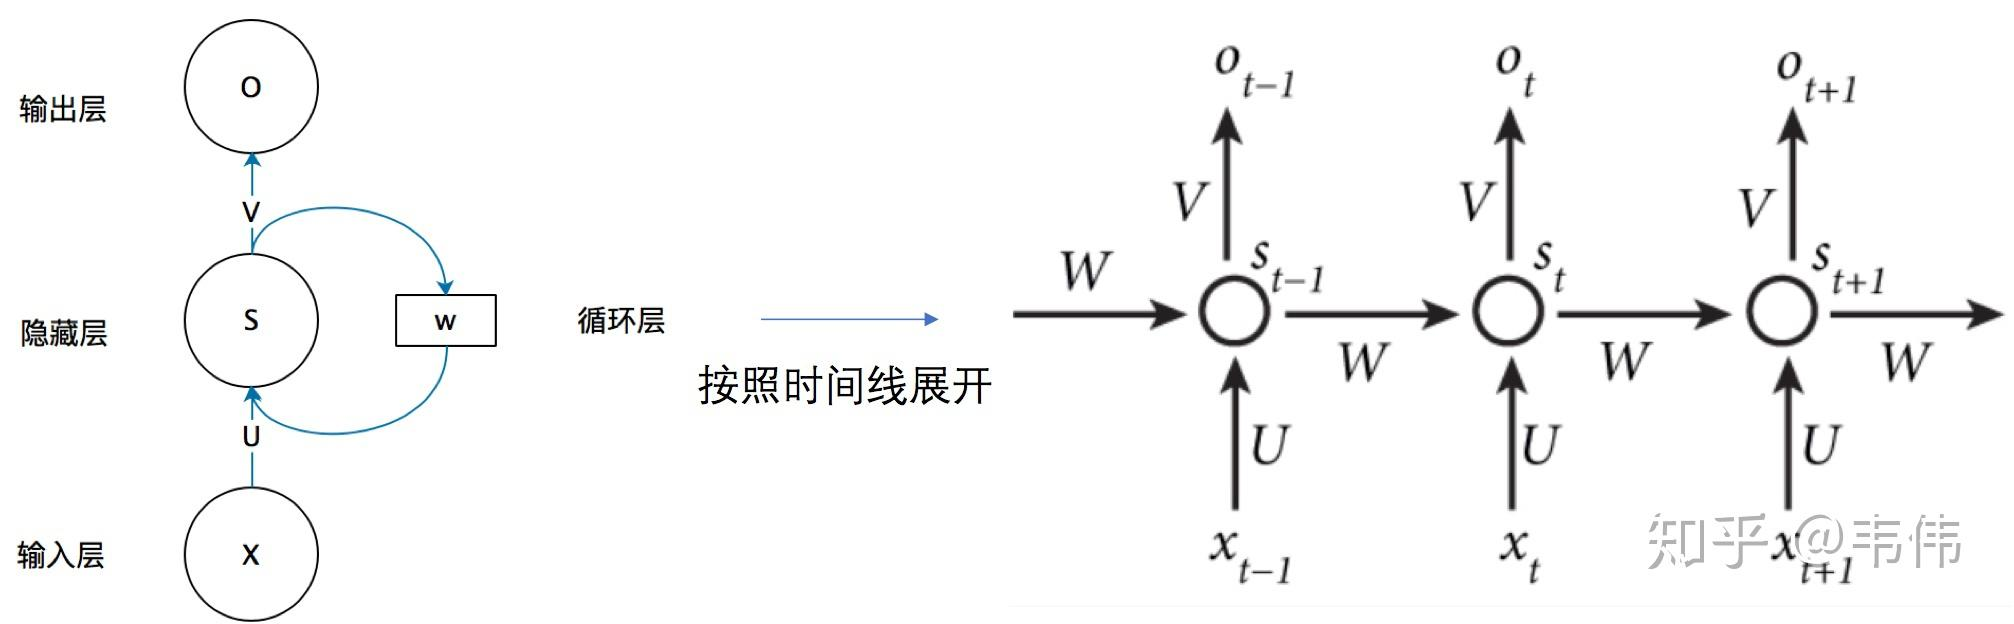

__算法解析__

输入层→隐藏层：首先附加权重（以下 $X$ 代表 $X_t$）
$$X\overset{U}{\rightarrow}UX$$
在将值传入激活函数 $f$ 之前，我们把隐藏状态的 $W$ 也一并传入，并读取上一时刻的记忆 $S_{t-1}$，然后将其与当前的 $X$ 进行拼接：
$$UX\overset{W}{\rightarrow}UX+WS_{t-1}$$
最后再将其传入激活函数：
$$S_t=f(UX+WS_{t-1})$$
并保持记忆 $S_t$ ，供下一时刻使用。

然后进入输出层，进行权重计算和激活函数计算：
$$O=g(VS_t)$$
迭代：$X_t\rightarrow X_{t+1}$

### 位置编码

Transformer中没有采用RNN，因此需要在输入时输入额外的序列位置信息。这里采用的是长周期正余弦交替编码的形式。图中纵轴代表序列中的位置，横轴代表在 $d_{model}$ 维度上的位置。因此每一行都代表一个序列中的 token 的位置编码。（DDPM）也是采用这种形式进行位置编码。

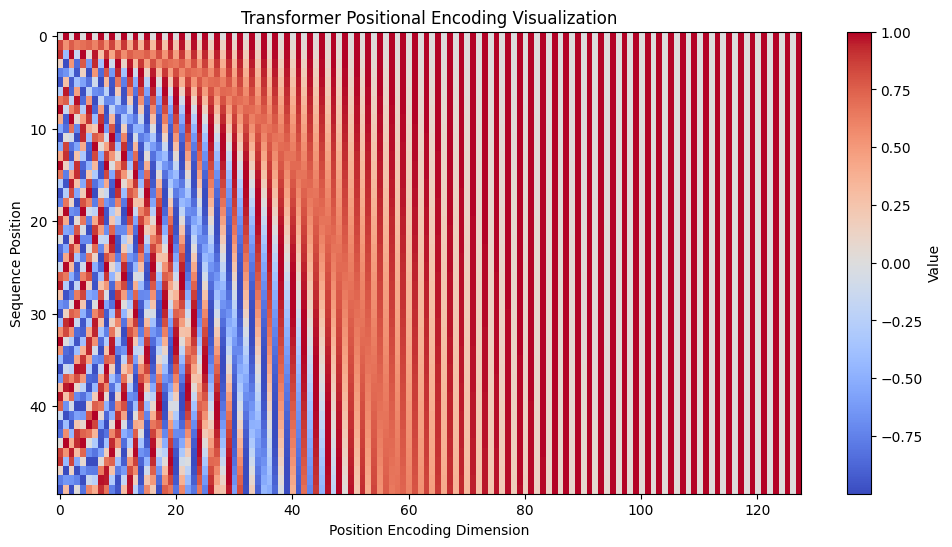

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def positional_encoding(seq_len, d_model):
    position = np.arange(seq_len)[:, np.newaxis]  # (50, 1)
    div_term = np.exp(np.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))  # (64,)
    pe = np.zeros((seq_len, d_model))
    pe[:, 0::2] = np.sin(position * div_term)
    pe[:, 1::2] = np.cos(position * div_term)
    return pe

# 生成位置编码
seq_length = 50
d_model = 128
pos_enc = positional_encoding(seq_length, d_model)

# 可视化
plt.figure(figsize=(12, 6))
plt.imshow(pos_enc, cmap='coolwarm', aspect='auto')
plt.xlabel('Position Encoding Dimension')
plt.ylabel('Sequence Position')
plt.colorbar(label='Value')
plt.title('Transformer Positional Encoding Visualization')
plt.show()

### 多头注意力机制
```cpp
h × 自注意力层->多头注意力层
```

输入的 token 矩阵先经过一个线性层，与可学习矩阵 $W_Q,W_K,W_V$ 相乘得到三个矩阵 $Q$,$K$,$V$。`Query,Key,Value`

接着传入 Self-Attention 模块:(Softmax在这里指的Softmax函数，不是名为Softmax回归的神经网络，以及这里与 $V$ 进行的是按位乘积)

<img src="https://pic1.zhimg.com/v2-26cf164e2ce740a7cc6afc1e237d88be_1440w.webp?consumer=ZHI_MENG" width="400" />

如果有 $h$ 层，那么就会输出 $h$ 个 $Z_i$ 。然后进入全连接层，得到：
$$
\begin{pmatrix}Z_1~Z_2~\cdots~Z_h\end{pmatrix}Linear=Z
$$

> 从线性代数的角度出发，假设 $X\in \mathbb{R}^{n\times d}$，其中 $n$ 表示序列长度，则 $W_Q,W_K,W_V\in \mathbb{R}^{d\times w}$，因此 $Q,K,V\in\mathbb{R}^{n\times w}$，最终结果 $Z\in\mathbb{R}^{n\times w}$。
> 
> 因此，可以认为，$Q,K,V$ 的 $(i,j)$ 元素包含了第 $i$ 个token的第 $j$ 个特征。进行矩阵乘积 $QK^T$ 实质上是计算token $i$ 与 $j$ 之间的内积，以此表征相似度。假设 $QK^T$ 为 $A$，则 $V$ 相当于对 $A$ 进行了加权求和。
>
> 这里计算出的结果表示的是，每个token与其他token之间的**标准化后的**相似度。

### 编码器


一个编码器由一个多头注意力层及其Add&Norm层和一个前馈网络层及其Add&Norm层组成。
```cpp
Encoder = MultiHeadAttention -> Add & Norm -> Feed Forward -> Add & Norm
```

Add&Norm即残差连接后使用层归一化：
$$\text{LayerNorm}(X+\underbrace{\text{Sublayer}(X)}_{前一层的输出})$$
FNN(前馈神经网络)可以理解为一个多层感知机。

对于输入的 $X$，$$\text{Encoder}(X)=\text{L}(\text{L}(X+\text{M}(X)))+FFN(\text{L}(X+\text{M}(X)))$$


我们往往有多个Encoder叠加，其原理可写为：
$$O=\underbrace{\text{Encoder}\circ\cdots\circ\text{Encoder}}_{n层}(X)$$

### 解码器（训练）

解码器的结构为
```cpp
Decoder = Masked_MultiHeadAttention -> Add & Norm -> Cross_MultiHeadAttention -> Add & Norm -> Feed Forward -> Add & Norm
```

这里我们输入目标序列。

其中第一个掩码多头注意力层只关注目标序列，利用加入掩码矩阵的自注意力层捕捉目标序列内部的依赖关系（比如捕捉目标句子"I am a student"之间的特征和关系）。

第二个交叉注意力层关注目标序列和源序列，即 $K,V$ 通过编码器的信息矩阵得到，表示原矩阵的信息；$Q$通过上一层的输出得到（比如捕捉目标句子"I am a student"和源句子"我是一个学生"之间的特征和关系）。

经过 $n$ 个解码器的输出后，进行线性变化和 Softmax 操作，得到最终的概率矩阵。并根据这个概率矩阵计算损失函数，更新模型参数。

在利用解码器进行推理时，则只会输入一个起始 token，然后根据解码器输出的概率预测下一个 token，不断重复这个过程。

### 总结
Transformer 通过位置编码实现了并行计算，通过自注意力机制将感受野扩大到了全局，能更好地捕捉长距离依赖关系。

## 离散潜变量空间

回顾 VAE 的损失函数：
$$\max\mathcal L(\phi,\theta)=
\underbrace{ \mathbb{E}_{q(z|x)}[\log p(x|z)] }_{\text{Reconstruct term } L_{Rec}} - \underbrace{ D_{KL}(q(z|x)||p(z)) }_{\text{KL term } L_{KL}}
$$

上述损失函数等价于最大化重建项和最小化 KL 散度项。因此，训练出的模型可能会“偷懒”将 $x$ 的信息忽略，直接采用先验 $p(z)$ 进行编码，从而导致数据未被有效利用。然后训练一个强大的解码器，使之重建项非常大，不使用 $x$ 的信息也能重建出 $x$。即posterior collapse问题。

VAE中的编码器采取根据一个正态分布将 $x$ 编码为潜在变量 $z$，$z$ 位于连续潜变量空间中。为了避免这个问题，VQ-VAE 采用离散潜变量空间，即编码为既有codebook中的离散向量，严格限制了“距离”。

然而，VQ-GAN中采用的均方误差只能使得像素值接近，而不能使得图像在感知上的特征接近，因此在后续工作 VQ-GAN 中，采用感知误差代替重建误差中的均方误差（取出中间某几层卷积层的特征，计算特征图像之间的均方误差），并引入GAN的判别器进行判断图块的真实性。

LDM 的感知压缩模型是基于以上工作的。

- 感知损失：关注图像的整体感知结构
- 对抗训练：避免局部的模糊现象，使之具有局部真实性，可以生成高分辨率图像
- 离散空间：保留更有意义的特征

# 潜在扩散模型

总论：LDM模型亮点在于
- 引入潜空间
- 引入交叉注意力机制，改进反向U-Net

## 总体结构

- 编码器 (E)：负责将像素空间的 $x$ 映射到潜在空间的 $z$。
- 前向扩散过程 (Forward Process of DDPM)：对潜在向量 $z$ 进行加噪处理，得到正态分布噪声 $z_T$。
- $\tau_{\theta}$ 编码器：处理文本等信息，将其编码，便于计算注意力。
- 去噪U-Net (Denoising U-Net)：由交叉注意力模块组成，$Q$ 接受潜变量 $z_t$，$K,V$ 接受文本编码。

文中并未给出两个编码器的结构，因此我们不展开讨论。

### 去噪U-Net

在DDPM的去噪过程中，从$x_t$到$x_{t-1}$的过程是用 U-Net 实现的，其中输入时间位编码作为条件，中间会经历数次上下采样以及卷积层，最后输出噪声预测 $\epsilon_{\theta,t}$

在LDM中，由于条件信息 $\tau_{\theta}(y)$ 的输入，我们需要引入交叉注意力机制：将编码扁平化处理，比对 $Q$ 与 $K$ 的相似度，以 $V$ 为权重，从而输出条件噪声预测 $\epsilon_{\theta,t,y}$

那么我们的损失函数就变为：
$$L_{LDM} := \mathbb{E}_{\mathcal{E}(x),y,\epsilon\sim\mathcal{N}(0,1),t} \left[ \left\| \epsilon - \epsilon_{\theta}(z_t, t, \tau_{\theta}(y)) \right\|_2^2 \right]$$

这相当于在DDPM损失函数的基础上作出了如下改动：进行条件去噪，在给定标签的条件下，去噪图片。因此我们训练出的结果会是：反向过程在保证条件 $y$ 实现的情况下，尽可能地使去噪后的图片 $\hat{x}$ 接近原始图片 $x$。

> DDPM：对图片进行上下采样，有时会使用注意力机制来表征图像中的特征关系。
> 
> LDM：嵌入条件信息，使用交叉注意力机制来融合图像和文本之间的特征关系。

因此，我们在训练中，可以同时优化 U-Net 和编码器 $\tau_{\theta}$